In [1]:
%pip install tensorflow==2.9.0
%pip install ampligraph
%pip install networkx
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

## Dataset

https://www.kaggle.com/datasets/saurabhshahane/music-dataset-1950-to-2019

In [70]:
df = pd.read_csv("tcc_ceds_music.csv").sort_values("release_date")

In [71]:
df.isna().sum()

Unnamed: 0                  0
artist_name                 0
track_name                  0
release_date                0
genre                       0
lyrics                      0
len                         0
dating                      0
violence                    0
world/life                  0
night/time                  0
shake the audience          0
family/gospel               0
romantic                    0
communication               0
obscene                     0
music                       0
movement/places             0
light/visual perceptions    0
family/spiritual            0
like/girls                  0
sadness                     0
feelings                    0
danceability                0
loudness                    0
acousticness                0
instrumentalness            0
valence                     0
energy                      0
topic                       0
age                         0
dtype: int64

Все значения ненулевые - ничего не дропаем

В трен. выборку все треки до 2014, в датасете с 1950 до 2019

In [72]:
df["train"] = df.release_date < 2013

In [73]:
df.train.value_counts()

train
True     24278
False     4094
Name: count, dtype: int64

## Создание графа знаний

In [7]:
triples = []
for i, row in df[df["train"]].iterrows():
    # Существующие отношения
    track = (row["track_name"], "isTrackOfArtist", row["artist_name"])
    track_genre = (row["track_name"], "hasGenre", row["genre"])
    release_date = (row["track_name"], "releasedOn", row["release_date"])
    sadness = (row["track_name"], "hasSadnessScore", row["sadness"])
    energy = (row["track_name"], "hasEnergy", row["energy"])
    danceability = (row["track_name"], "hasDanceability", row["danceability"])
    topic = (row["track_name"], "hasTopic", row["topic"])

    # Новые отношения
    # Отношение между треком и эпохой (десятилетие)
    era = f"{int(row['release_date']) // 10 * 10}s"  # Пример: "1950s"
    track_era = (row["track_name"], "belongsToEra", era)

    # Отношение между артистом и жанром
    artist_genre = (row["artist_name"], "createsInGenre", row["genre"])

    # Трек и жанр вызывают эмоцию или темы
    genre_emotion = (row["genre"], "invokesEmotion", row["topic"])
    track_emotion = (row["track_name"], "invokesEmotion", row["topic"])

    # Отношения сравнения между треками (на основе танцевальности и громкости)
    for _, compare_row in df[i:i+10].iterrows():
        if row["track_name"] != compare_row["track_name"]:
            if row["danceability"] > compare_row["danceability"]:
                comparison = (row["track_name"], "moreDanceableThan", compare_row["track_name"])
                triples.append(comparison)
            if row["loudness"] > compare_row["loudness"]:
                comparison = (row["track_name"], "louderThan", compare_row["track_name"])

    # Отношения между треками одного артиста (например, сотрудничество)
    if row["artist_name"] == compare_row["artist_name"]:
        collab = (row["track_name"], "collaboratesWith", compare_row["track_name"])
        triples.append(collab)

    # Добавить все триплеты для этой строки
    triples.extend([track, track_genre, release_date, sadness, energy, danceability, topic, track_era, artist_genre, genre_emotion, track_emotion])

# Пример: вывод нескольких триплетов
for triple in triples[:10]:
    print(triple)

('mohabbat bhi jhoothi', 'moreDanceableThan', 'three wishes')
('mohabbat bhi jhoothi', 'moreDanceableThan', 'just for fun')
('mohabbat bhi jhoothi', 'moreDanceableThan', 'absence makes the heart grow fonder (for somebody else)')
('mohabbat bhi jhoothi', 'moreDanceableThan', 'vieni su (say you love me, too)')
('mohabbat bhi jhoothi', 'isTrackOfArtist', 'mukesh')
('mohabbat bhi jhoothi', 'hasGenre', 'pop')
('mohabbat bhi jhoothi', 'releasedOn', 1950)
('mohabbat bhi jhoothi', 'hasSadnessScore', 0.380298895230333)
('mohabbat bhi jhoothi', 'hasEnergy', 0.1371101880258922)
('mohabbat bhi jhoothi', 'hasDanceability', 0.3577385465179248)


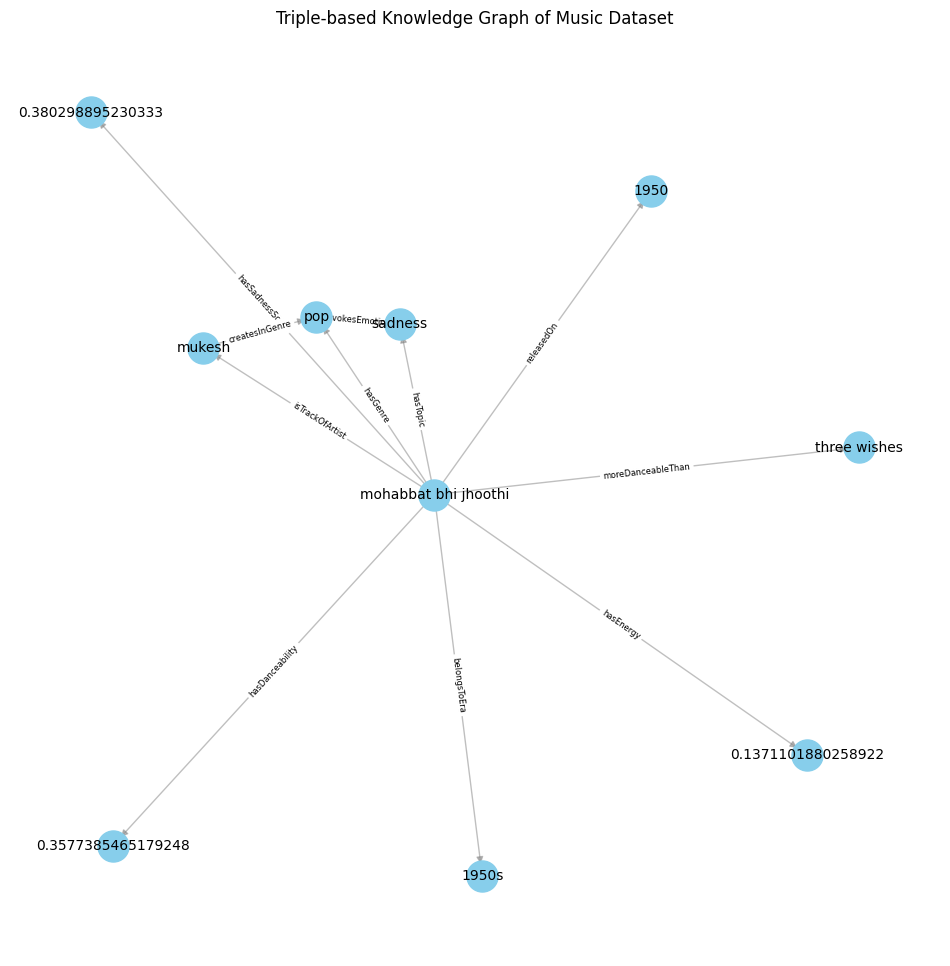

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Инициализируем направленный граф
G = nx.DiGraph()
predicates = []

# Добавляем узлы и ребра на основе триплетов
for triple in triples[:20]:
    subject, predicate, object_ = triple

    # Добавляем узлы для субъекта и объекта, если они еще не в графе
    if predicate in predicates:
      continue
    if subject not in G:
        G.add_node(subject)
    if object_ not in G:
        G.add_node(object_)

    # Добавляем ребро между субъектом и объектом с предикатом как меткой ребра
    predicates.append(predicate)
    G.add_edge(subject, object_, label=predicate)

# Определяем разметку для лучшей визуализации
pos = nx.spring_layout(G, seed=42)  # Расположение узлов с использованием пружинной разметки

# Рисуем граф
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.0, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['label'] for u, v, d in G.edges(data=True)}, font_size=6)

# Отображаем граф
plt.title("Граф знаний на основе триплетов из музыкального набора данных")
plt.axis("off")  # Скрыть оси
plt.show()

In [9]:
# Создаем DataFrame из списка триплетов
# Устанавливаем названия колонок как "subject", "predicate" и "object"
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])

# Фильтруем DataFrame для получения только тех строк, где
# либо "subject" равно "mohabbat bhi jhoothi",
# либо "object" равно "mukesh"
filtered_triples = triples_df[(triples_df.subject == "mohabbat bhi jhoothi") | (triples_df.object == "mukesh")]

# Показать отфильтрованные данные
filtered_triples

,subject,predicate,object
0,mohabbat bhi jhoothi,moreDanceableThan,three wishes
1,mohabbat bhi jhoothi,moreDanceableThan,just for fun
2,mohabbat bhi jhoothi,moreDanceableThan,absence makes the heart grow fonder (for someb...
3,mohabbat bhi jhoothi,moreDanceableThan,"vieni su (say you love me, too)"
4,mohabbat bhi jhoothi,isTrackOfArtist,mukesh
5,mohabbat bhi jhoothi,hasGenre,pop
6,mohabbat bhi jhoothi,releasedOn,1950
7,mohabbat bhi jhoothi,hasSadnessScore,0.380299
8,mohabbat bhi jhoothi,hasEnergy,0.13711
9,mohabbat bhi jhoothi,hasDanceability,0.357739


## Тренировка эмбедингов в графе знаний

In [10]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [11]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (376602, 3)
Test set size:  (10000, 3)


In [12]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

# Создание модели
model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

# Определение оптимизатора, функции потерь и регуляризатора
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Компиляция модели
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

AmpliGraph реализовал несколько моделей встраивания графов знаний (TransE, ComplEx, DistMult, HolE), но для начала мы просто собираемся использовать сложную модель, которая, как известно, обладает самыми современными возможностями прогнозирования.

Выбор гиперпараметров был основан на наилучших результатах, которые мы нашли на данный момент для комплексной модели, применяемой к некоторым контрольным наборам данных, используемым сообществом по встраиванию графов знаний. В этом руководстве не рассматривается настройка гиперпараметров.

Давайте пройдемся по параметрам, чтобы понять, что происходит:

k: размерность пространства вложения.

eta ( eta ) : количество отрицательных или ложных триплетов, которые должны быть сгенерированы во время выполнения обучения для каждой положительной или истинной триплетов.

scoring_type: тип модели, определяемый конкретной функцией подсчета очков.

seed: случайное начальное значение, используемое для воспроизводимости.

optimizer: оптимизатор Adam со скоростью обучения 1e-4, задаваемой с помощью параметра kwarg optimizer_params.

loss : попарный проигрыш с запасом в 0,5, установленным с помощью параметра loss_params kwarg.

regularizer : регуляризация Lp с p = 3 , т.е. Регуляризация l3.  лямбда = 1e-5, задается с помощью параметра regularizer_params kwarg.

ВАРНИНГ: тренировка займёт около 10 минут на современном ЦПУ

In [13]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=20, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/20
52/52 [==============================] - 44s 845ms/step - loss: 22481.6406
Epoch 2/20
52/52 [==============================] - 42s 816ms/step - loss: 22480.9316
Epoch 3/20
52/52 [==============================] - 40s 763ms/step - loss: 22479.4277
Epoch 4/20
52/52 [==============================] - 41s 779ms/step - loss: 22476.6035
Epoch 5/20
52/52 [==============================] - 38s 726ms/step - loss: 22471.8672
Epoch 6/20
52/52 [==============================] - 38s 729ms/step - loss: 22464.5391
Epoch 7/20
52/52 [==============================] - 41s 782ms/step - loss: 22453.8750
Epoch 8/20
52/52 [==============================] - 47s 899ms/step - loss: 22439.0801
Epoch 9/20
52/52 [==============================] - 40s 771ms/step - loss: 22419.3691
Epoch 10/20
52/52 [==============================] - 38s 733ms/step - loss: 22393.9961
Epoch 11/20
52/52 [==============================] - 51s 981ms/step - loss: 22362.2324
Epoch 12/20
52/52 [==============================] -

## Проверка эмбедингов

AmpliGraph стремится следовать философии дизайна scikit-learn, основанной на простоте использования, и упрощать все вплоть до функций "подгонки", "оценки" и "прогнозирования".

Тем не менее, мы должны предпринять некоторые шаги, связанные с графом знаний, чтобы обеспечить корректное обучение и оценку нашей модели. Первый из них - это определение фильтра, который будет использоваться для обеспечения того, чтобы никакие отрицательные утверждения, сгенерированные в результате процедуры проверки на коррупцию, на самом деле не были положительными. Это можно сделать, просто объединив наши обучающие и тестовые наборы. Теперь, когда стратегия искажения генерирует отрицательные тройки, мы можем проверить, что они на самом деле не являются истинными утверждениями.

Для этого мы будем использовать метод `evaluate` объекта model:

- **`X_valid`** - данные для оценки. Мы собираемся использовать наш тестовый набор для оценки.
- **`use_filter`** - будет отфильтровывать ложноотрицательные результаты, генерируемые стратегией коррупции.
- **`corrupt_side"** - определяет подход к тройной коррупции. параметр "s,o" означает значение "True", тогда subj и obj будут повреждены отдельно во время оценки.
- **"verbose"** - отображает индикатор выполнения.

In [14]:
# Оценка модели на валидационном наборе данных
ranks = model.evaluate(
    X_valid,
    use_filter={'train': X_train, 'test': X_valid},  # Фильтруем по тренировочным и валидационным триплетам
    corrupt_side='s,o',  # Указываем, что коррумпировать будем субъект и объект
    verbose=True  # Включаем вывод прогресса на экран
)

1001/1001 [==============================] - 332s 332ms/step


Мы собираемся использовать функции mrr_score (среднее значение взаимного ранжирования) и hits_at_n_score.

- **mrr_score**: Функция вычисляет среднее значение взаимного значения элементов вектора рангов рейтинга.
- **hits_at_n_score**: Функция вычисляет, сколько элементов вектора рейтинговых рангов попадают на верхние n позиций.

In [15]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

# Вычисление среднего ранга (Mean Rank, MR)
mr = mr_score(ranks)

# Вычисление среднего обратного ранга (Mean Reciprocal Rank, MRR)
mrr = mrr_score(ranks)

# Вывод средного обратного ранга
print("MRR: %.2f" % mrr)

# Вывод среднего ранга
print("MR: %.2f" % mr)

# Вычисление метрики Hits@10 - процент случаев, в которых правильные ответы
# попадают в топ-10 предсказанных
hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % hits_10)

# Вычисление метрики Hits@3
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % hits_3)

# Вычисление метрики Hits@1
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % hits_1)

MRR: inf
MR: 4976.97
Hits@10: 0.27
Hits@3: 0.22
Hits@1: 0.16


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\ampligraph\evaluation\metrics.py:152: RuntimeWarning: divide by zero encountered in divide
  return np.sum(1 / ranks) / len(ranks)


Мы можем интерпретировать эти результаты, утверждая, что модель в 34% случаев относит правильный объект к топ-3 возможных вариантов.

Самих по себе этих показателей недостаточно, чтобы сделать вывод о полезности встраиваний в последующую задачу, но они предполагают, что встраивания усвоили достаточно разумное представление, чтобы рассмотреть возможность их использования в большем количестве задач.

## Кластеризация и визуализация эмбедингов

Чтобы оценить субъективное качество вложений, мы можем визуализировать вложения в двумерном пространстве, а также сгруппировать их в исходном пространстве. Мы можем сравнить кластеризованные вложения с естественными кластерами, в данном случае с континентом, откуда родом команда, чтобы у нас была основа для оценки качества кластеризации как в качественном, так и в количественном отношении.

In [16]:
%pip install adjustText
%pip install seaborn


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

In [18]:
# Создаем словарь, сопоставляющий трек с жанром
track_to_genre_map = {**dict(zip(df.track_name, df.genre))}

# Функция для получения жанра по названию трека
def map_track_to_genre(track_name):
    return track_to_genre_map.get(track_name, None)  # Используем get для безопасного извлечения жанра

Создаем словарь с эмбеддингами всех команд:


In [19]:
# Получаем уникальные имена треков из обучающего набора
tracks = df.track_name[df["train"]].unique()

# Получение эмбеддингов для всех уникальных треков
track_embeddings = dict(zip(tracks, model.get_embeddings(tracks)))

Используем метод PCA для проекции эмбеддингов из 200-мерного пространства в 2D-пространство:


In [20]:
# Преобразуем эмбеддинги треков в двумерное пространство с использованием PCA
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in track_embeddings.values()]))

Кластеризуем эмбеддинги команд в их оригинальном 200-мерном пространстве используя метод find_clusters из нашего Discovery API:


In [21]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

# Инициализируем алгоритм кластеризации K-Means
clustering_algorithm = KMeans(
    n_clusters=6,  # Количество кластеров, на которые мы хотим поделить данные
    n_init=50,     # Количество различных начальных конфигураций
    max_iter=500,  # Максимальное число итераций для одного запуска алгоритма
    random_state=0 # Фиксируем начальное состояние для воспроизводимости результатов
)

# Находим кластеры для треков с использованием обученной модели и алгоритма кластеризации
clusters = find_clusters(
    tracks,            # Список треков для кластеризации
    model,             # Обученная модель, предоставляющая эмбеддинги для треков
    clustering_algorithm,  # Алгоритм кластеризации
    mode='e'           # Указывает, что кластеризация должна выполняться в эмбеддинговом пространстве
)

DataFrame содержит для каждой команды их проецированные эмбеддинги в 2D-пространстве через PCA, их континент и кластер KMeans. Используем это вместе с Seaborn для создания визуализаций.


In [22]:
# Создаем DataFrame для визуализации, включающий треки и их двумерные эмбеддинги,
# а также жанры и кластеры, к которым они принадлежат
plot_df = pd.DataFrame({
    "tracks": tracks,  # Имена треков
    "embedding1": embeddings_2d[:, 0],  # Первая компонента двумерных эмбеддингов
    "embedding2": embeddings_2d[:, 1],  # Вторая компонента двумерных эмбеддингов
    "genre": pd.Series(tracks).apply(map_track_to_genre),  # Жанр каждого трека
    "cluster": "cluster" + pd.Series(clusters).astype(str)  # Идентификатор кластера для каждого трека, с префиксом "cluster"
})

We plot the results on a 2D scatter plot, coloring the teams by the continent or cluster and also displaying some individual team names.

We always display the names of the top 20 teams (according to [FIFA rankings](https://en.wikipedia.org/wiki/FIFA_World_Rankings)) and a random subset of the rest.

Отображаем результаты на 2D-диаграмме рассеивания, раскрашивая команды по континентам или кластерам и выводим названия некоторых отдельных команд.

Отображаем названия топ-20 команд (согласно рейтингу FIFA) и случайный поднабор остальных.


In [23]:
# Список из 20 популярных треков
top20tracks = [
    "i believe", "mohabbat bhi jhoothi", "cry", "patricia", "apopse eida oneiro",
    "it's not for me to say", "klapse me mana klapse me", "finito la mouzika",
    "carolina moon", "necessary evil", "chicken reel", "blue skies", "dark eyes",
    "sleep", "love me", "blue christmas", "right now!", "granada", "moonglow", "rock house"
]

# Функция для отображения кластеров с выделением
def plot_clusters(hue):
    np.random.seed(0)  # Фиксируем сид для воспроизводимости случайных чисел
    plt.figure(figsize=(12, 12))  # Устанавливаем размер фигуры
    plt.title("{} embeddings".format(hue).capitalize())  # Заголовок графика

    # Создаем scatter plot с использованием seaborn
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue, palette="viridis", alpha=0.7, edgecolor=None)

    texts = []  # Список для хранения текстовых экземпляров
    limit = 0
    for i, point in plot_df.iterrows():
        if limit > 1000:  # Ограничение на количество подписываемых точек
            break
        if point["tracks"] in top20tracks:
            # Добавляем подпись только для популярных треков
            texts.append(plt.text(point['embedding1'] + 0.02, point['embedding2'] + 0.01, str(point["tracks"])))
        limit += 1

    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red', linewidth=0.5))  # Корректировка размещения текста
    plt.show()  # Отображаем график

Первая визуализация 2D-эмбеддингов показывает естественные географические кластеры, которые можно рассматривать как форму "истинной" картины:

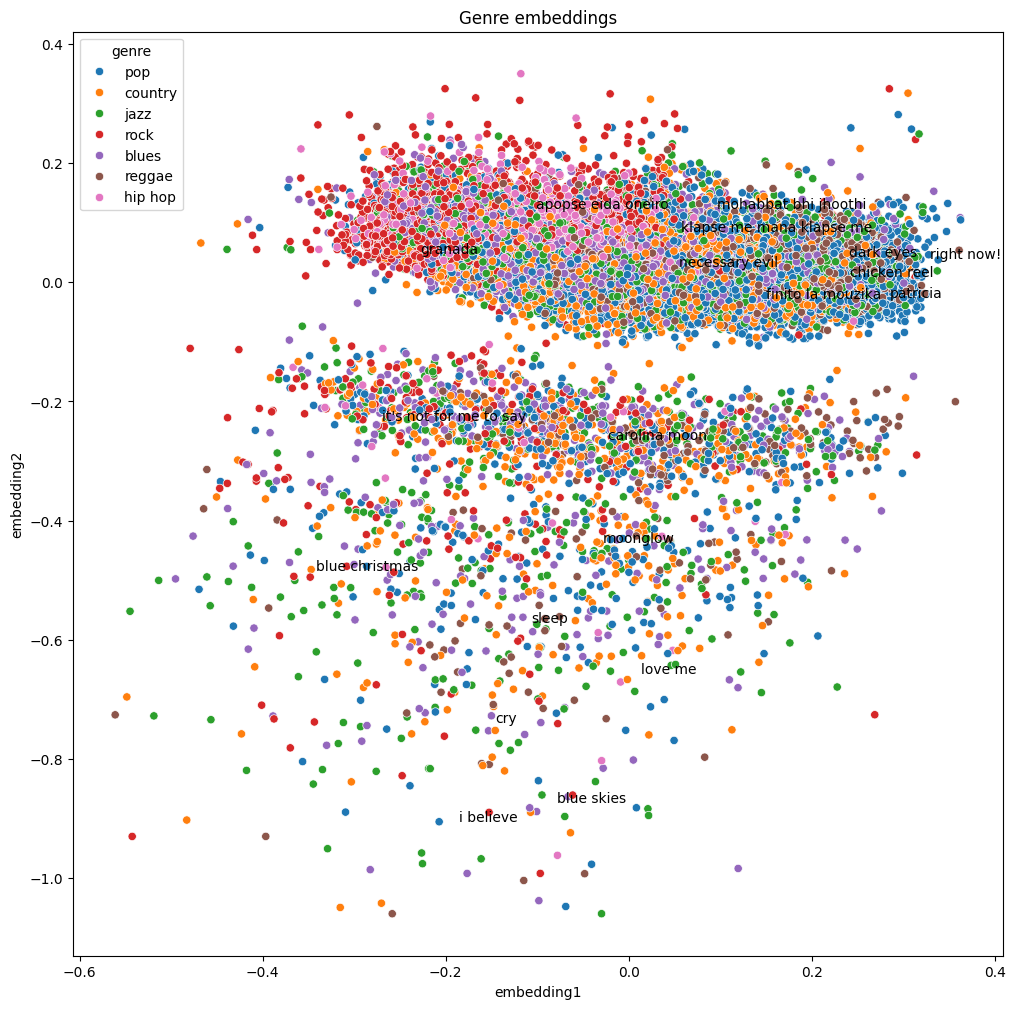

In [24]:
plot_clusters("genre")

Видим, что эмбеддинги выявили географические сходства, даже несмотря на то, что эта информация не была явно указана в оригинальном наборе данных.

Отображаем те же 2D-эмбеддинги, но с кластерами, найденными с помощью K-Means:

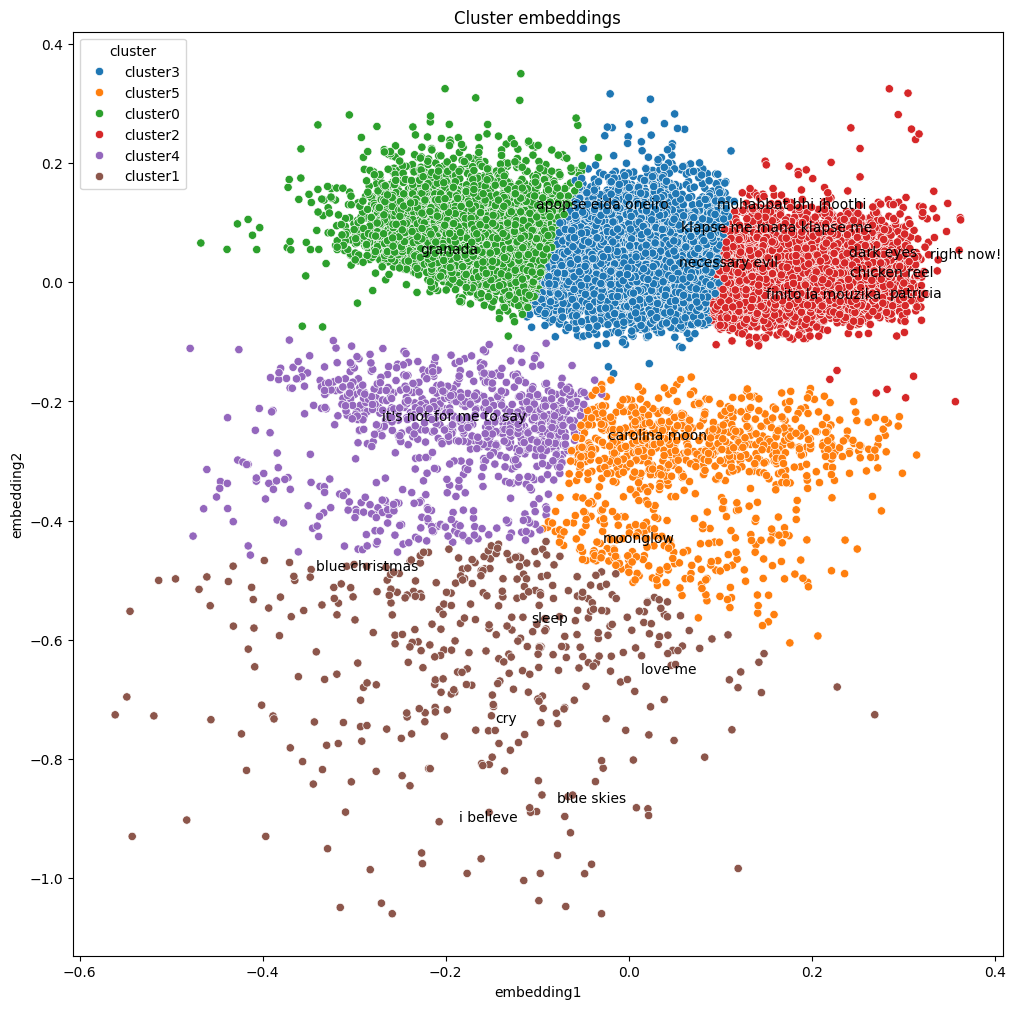

In [25]:
plot_clusters("cluster")

Можно заметить, что K-Means обнаружил кластеры, очень похожие на естественные географические кластеры по континентам. Это показывает, что в 200-мерном пространстве эмбеддингов похожие команды располагаются близко друг к другу, что может быть выявлено алгоритмом кластеризации.

Наша оценка кластеров может быть более объективной с использованием метрики, такой как скорректированный индекс Рэнда, который варьируется от -1 до 1, где 0 означает случайное распределение меток, а 1 — идеальное совпадение.


In [26]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.genre, plot_df.cluster)

0.04711220505635648

## Классификация

Используем эмбеддинги, чтобы предсказывать будущие матчи как задачу классификации.

Смоделируем её как многоклассовую задачу с тремя классами: победа домашней команды, поражение домашней команды, ничья.

Эмбеддинги используются непосредственно как признаки для классификатора XGBoost.

Сначала нам нужно определить целевую переменную:



In [74]:
# Получаем уникальные жанры из DataFrame и сохраняем их в список
genres = list(df.genre.unique())

# Создаем новый столбец 'results' в DataFrame
# Каждый жанр преобразуется в уникальный индекс
df["results"] = df.genre.apply(lambda g: genres.index(g)).astype(int)

In [75]:
df.results.value_counts(normalize=True)

results
0    0.248202
3    0.191915
2    0.162273
4    0.142182
1    0.135521
5    0.088045
6    0.031862
Name: proportion, dtype: float64

### Оригинальный датасет

Устанавливаем xgboost

In [76]:
%pip install xgboost


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [94]:
new_df = df[["results", "train"]].copy()
new_df

,results,train
0,0,True
17096,1,True
17097,1,True
17098,1,True
17099,1,True
...,...,...
7025,0,False
7026,0,False
7027,0,False
7009,0,False


Применяем one hot кодирование


In [95]:
import re
import pandas as pd

# Заменяем все символы кроме букв на 'x'
df['track_name'] = df['track_name'].apply(lambda t: re.sub(r'[^a-zA-Z]', 'x', t))
df['artist_name'] = df['artist_name'].apply(lambda t: re.sub(r'[^a-zA-Z]', 'x', t))

# Кодирование категориальных столбцов с помощью метода "one-hot encoding"
encoded_cols = pd.get_dummies(df[["track_name", "release_date", "artist_name", "dating", "violence"]])

# Отображаем закодированные столбцы
encoded_cols

,release_date,dating,violence,"track_name_""40""","track_name_""african head charge""","track_name_""b"" movie box car blues","track_name_""belle"" of the earth","track_name_""it’s a good day""",track_name_#!*@ me,track_name_#1 crush,...,artist_name_zontanoi nekroi,artist_name_zoot sims,artist_name_zuco 103,artist_name_zulú hip hop jam,artist_name_zz top,artist_name_ødyssee,artist_name_željko bebek,artist_name_дэфолиант,artist_name_張露,artist_name_彭家麗
0,1950,0.000598,0.063746,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17096,1950,0.002392,0.002392,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17097,1950,0.002193,0.002193,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17098,1950,0.003096,0.003096,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17099,1950,0.001645,0.001645,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7025,2019,0.017944,0.000849,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7026,2019,0.000763,0.128205,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7027,2019,0.023184,0.000543,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7009,2019,0.089621,0.000446,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [96]:
new_df = new_df.join(encoded_cols)

In [97]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
new_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in new_df.columns.values]
new_df

,results,train,release_date,dating,violence,"track_name_""40""","track_name_""african head charge""","track_name_""b"" movie box car blues","track_name_""belle"" of the earth","track_name_""it’s a good day""",...,artist_name_zontanoi nekroi,artist_name_zoot sims,artist_name_zuco 103,artist_name_zulú hip hop jam,artist_name_zz top,artist_name_ødyssee,artist_name_željko bebek,artist_name_дэфолиант,artist_name_張露,artist_name_彭家麗
0,0,True,1950,0.000598,0.063746,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17096,1,True,1950,0.002392,0.002392,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17097,1,True,1950,0.002193,0.002193,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17098,1,True,1950,0.003096,0.003096,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17099,1,True,1950,0.001645,0.001645,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7025,0,False,2019,0.017944,0.000849,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7026,0,False,2019,0.000763,0.128205,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7027,0,False,2019,0.023184,0.000543,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7009,0,False,2019,0.089621,0.000446,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Создаем многоклассовую модель.


In [80]:
from xgboost import XGBClassifier

In [104]:
clf_model: XGBClassifier = XGBClassifier(n_estimators=50, max_depth=5, objective="multi:softmax")

In [98]:

X_train = new_df[df["train"]].drop(["results"], axis=1)
y_train = new_df[df["train"]].results
X_val = new_df[~df["train"]].drop(["results"], axis=1)
y_val = new_df[~df["train"]].results


In [105]:
clf_model.fit(X_train, y_train, verbose=True)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Результат

In [106]:
from sklearn import metrics
metrics.accuracy_score(y_val, clf_model.predict(X_val))

0.3475818270639961

### Графовые эмбединги

Создадим функцию, которая извлекает признаки и целевую переменную для конкретного подмножества набора данных.


In [47]:
from sklearn.preprocessing import LabelEncoder

def get_features_target(mask):

    def get_embeddings(team):
        return track_embeddings.get(team, np.full(200, np.nan))

    X = np.hstack((np.vstack(df[mask].track_name.apply(get_embeddings).values),
                   np.vstack(df[mask].artist_name.apply(get_embeddings).values)))
    y = df[mask].genre.values

    # Convert y labels to integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return X, y_encoded

In [48]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

print(clf_X_train, y_train)

[[-0.01239794 -0.00320096 -0.0258264  ...         nan         nan
          nan]
 [-0.03335699 -0.01568718 -0.07796062 ...         nan         nan
          nan]
 [ 0.01284751 -0.02224274 -0.01783132 ...         nan         nan
          nan]
 ...
 [-0.03268252 -0.01883395 -0.04054969 ...         nan         nan
          nan]
 [-0.03572163 -0.01426126 -0.0391349  ...         nan         nan
          nan]
 [-0.01963679 -0.02501229 -0.03638614 ...         nan         nan
          nan]] [4 3 3 ... 1 1 1]


In [49]:
clf_X_train.shape, clf_X_test.shape

((24278, 400), (4094, 400))

У нас по 200 признаков на команду, потому что модель ComplEx использует как мнимую, так и действительную часть для своих эмбеддингов, так что у нас в два раза больше параметров по сравнению с определением k=100 в её модели.

У нас также есть некоторая недостающая информация из эмбеддингов сущностей, которые появляются только в тестовом наборе данных и которые вряд ли будут правильно классифицированы.


In [50]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

3725.5

Создаем многоклассовую модель с 500 оценщиками


In [39]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

Обучаем модель, используя все обучающие образцы.


In [51]:
clf_model.fit(clf_X_train, y_train)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Базовая точность для этой задачи составляет 47%, так как это частота самой распространенной категории.


In [52]:
df[~df["train"]].results.value_counts(normalize=True)

results
0    0.207132
2    0.155594
4    0.146556
6    0.131412
1    0.125305
5    0.117733
3    0.116268
Name: proportion, dtype: float64

In [53]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.14069369809477283

Хотя базовая точность для этой задачи классификации была 47%, только на основе эмбеддингов мы смогли создать классификатор, который достигает точности в 53%.

В будущем можно добавить больше характеристик в модель (не связанных с эмбеддингами) и настроить гиперпараметры модели.


## Link prediction

Предсказание связей позволяет нам восстанавливать пропущенные связи в графе


In [54]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [55]:
df = pd.DataFrame(X_train,columns = ['subject','predicate','object'])
trackSubject = "i believe"
print(df[df.subject==trackSubject])

          subject          predicate               object
1480    i believe    hasDanceability   0.8819451965774937
1774    i believe  moreDanceableThan              ashamed
4809    i believe          hasEnergy    0.526511738905159
8710    i believe         releasedOn                 1995
8836    i believe    hasSadnessScore   0.1041755024599041
...           ...                ...                  ...
350484  i believe  moreDanceableThan  days is almost gone
361049  i believe    isTrackOfArtist          diamond rio
370415  i believe          hasEnergy   0.2031783174809864
373404  i believe    hasSadnessScore   0.0012836971300268
375859  i believe       belongsToEra                1970s

[128 rows x 3 columns]


In [56]:
dfFiltered = np.array(df[(df.subject!=trackSubject) | ((df.subject==trackSubject) & ~df.predicate.isin(["genre"]))])

Обучим модель

In [57]:
model.fit(dfFiltered, epochs=20)

Epoch 1/20
378/378 [==============================] - 74s 195ms/step - loss: 16564.6680
Epoch 2/20
378/378 [==============================] - 75s 198ms/step - loss: 13585.1982
Epoch 3/20
378/378 [==============================] - 76s 201ms/step - loss: 11634.9404
Epoch 4/20
378/378 [==============================] - 81s 215ms/step - loss: 10251.0244
Epoch 5/20
378/378 [==============================] - 79s 210ms/step - loss: 9211.8076
Epoch 6/20
378/378 [==============================] - 79s 208ms/step - loss: 8398.4912
Epoch 7/20
378/378 [==============================] - 77s 204ms/step - loss: 7742.0972
Epoch 8/20
378/378 [==============================] - 78s 206ms/step - loss: 7199.7563
Epoch 9/20
378/378 [==============================] - 78s 207ms/step - loss: 6743.2812
Epoch 10/20
378/378 [==============================] - 78s 208ms/step - loss: 6353.2241
Epoch 11/20
378/378 [==============================] - 77s 204ms/step - loss: 6015.7256
Epoch 12/20
378/378 [================

Создадим несколько утверждений для жанров

In [58]:
statements = np.array([
    [f'{trackSubject}', 'hasGenre', 'pop'],
    [f'{trackSubject}', 'hasGenre', 'country'],
    [f'{trackSubject}', 'hasGenre', 'blues'],
    [f'{trackSubject}', 'hasGenre', 'rock'],
    [f'{trackSubject}', 'hasGenre', 'jazz'],
])

Объединим тройки графа с предложенными утверждениями.

In [59]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
statements_filter

array([['wonderland of love', 'hasTopic', 'world/life'],
       ['used to rule the world', 'hasSadnessScore',
        '0.0010964912738118'],
       ['pieces of me', 'belongsToEra', '2000s'],
       ...,
       ["you're a sweetheart", 'moreDanceableThan',
        'black no. 1 (little miss scare -all)'],
       ['make love to me', 'moreDanceableThan', 'down on my knees'],
       ['love', 'moreDanceableThan', 'turntable']], dtype='<U163')

In [60]:
ranks = model.evaluate(statements,
                      use_filter={'train': dfFiltered,
                                  'test': statements},
                      corrupt_side='s,o',
                      verbose=True)

2/2 [==============================] - 1s 669ms/step


In [61]:
scores = model.predict(statements)
scores

array([7.2024593, 6.902708 , 6.664133 , 6.1127653, 6.9539156],
      dtype=float32)

Выведем результат предсказаний

In [62]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in statements],
                      ranks,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("prob")

,statement,rank,score,prob
3,i believe hasGenre rock,"[28, 0]",6.112765,0.997790
2,i believe hasGenre blues,"[13, -1]",6.664133,0.998726
1,i believe hasGenre country,"[7, -1]",6.902708,0.998996
4,i believe hasGenre jazz,"[2, 0]",6.953916,0.999046
0,i believe hasGenre pop,"[0, 0]",7.202459,0.999256


### Наша модель правильно угадывает жанр по названию песни, группе и другим параметрам!